## EDA of manually labeled URL data

100 Municipalites and their URLs were checked and labeled. The annotation have comments and a rater confidence score.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re   
import nltk

In [2]:
df = pd.read_csv('../data/HumanAnnotated.csv')

# Step 2: Get all rows that have Label != NaN
labeled_rows = df[df['Label'].notna()]

# Step 3: Get percentage of 0, 1 and 2 labels
label_counts = labeled_rows['Label'].value_counts(normalize=True) * 100

# Step 4: Get confidence average
average_confidence = labeled_rows['Confidence'].mean()

# Step 5: Get all individual comments of 0 labels and analyze them by hand
comments_0 = labeled_rows[labeled_rows['Label'] == 0]['Comment'].tolist()

# Step 6: Get all individual comments of 2 labels and analyze them by hand
comments_2 = labeled_rows[labeled_rows['Label'] == 2]['Comment'].tolist()

### Label Percentages

- 0 (= not correct website)
- 1 (= correct website)
- 2 (= website error)

In [3]:
label_counts

Label
1.0    87.387387
0.0     8.108108
2.0     4.504505
Name: proportion, dtype: float64

### Average Rater Confidence:

In [4]:
average_confidence

97.74774774774775

### Comments for 0 Label:

In [5]:
comments_0

['municipality is lopuchov, strelniky website can be found with a google search',
 'website is from a municipality with a bigger name, googling la pena makes a wikipedia page appear for la pena without additional words which has another website linked. which wikipedia site was used to crawl the url name?',
 'different name of municipalities',
 'wrong municipality',
 'typo, municipality url should be for unehle and not ulehle',
 "website leads to parent website of the municipality, municipality itself doesn't have a website",
 'wrong municipality website, malas has own wikipedia website with the correct website link',
 'wrong website',
 'airport website not municipality']

### Key takeaways from comments for incorrect websites:

- wrong municipality url crawled with different name (url or website content is significantly different most of the times)
- right municipality can be found easily using google and clicking on correct wikipedia link. One had a bad link on the german article and a correct link on the english article.
- many wrong websites are still municipalities, which could be hard to detect
- if website is for a different topic (airport), it could be easier to detect but the website url can still have the name of the municipality in it so only checking for name of municipality in url or website content is not enough

### Comments for 2 Label:

In [6]:
comments_2

['404, but base url is parent website of many municipalities in an "amt" in germany',
 "this site can't be reached, website name changed to include hyphen, new website can be easily found with google",
 'english wikipedia has the correct website, german wikipedia has old website which says "this page is under construction - coming soon"',
 'subsite of parent website for "amt" in germany, "Seite nicht gefunden", real website can be found easily with google',
 'forbidden error message, real website can be found with google, it has a hyphen and a .cz.it domain suffix']

### Key takeaways from comments for website errors:

- website can't be reached because url is invalid.
- page under construction, seite nicht gefunden, forbidden, etc.
    - could be distinguished using clustering algorithm or specific keywords?

In addition to these takeaways, correct websites' comments often times have a specific keyword (translated to english) in them, which was used to label the data. Some also had a map or generally a lot of government or tourism specific information on them.

## Classification Conditions for True Positives (Label 1 = correct website)

The two main conditions for a correct website are:
- website url contains municipality name
- website content contains municipality name

These were taken from decision trees over the complete data set. These are the engineered features:
- is municipality name in url (unidecoded and lowered)
- is municipality name in website content (unidecoded and lowered)
- count error keywords in website content
- count keywords in url (english and translated)
- count keywords in content (english and translated)

Further features can be engineered: 
- how many times the name of the municipality occurs in subwebsites (subsites revolve around the specific municipality).

## Rule Based Approach

- use the features engineered above
- take conditions out of them (automatically generated by decision tree)
- maybe use score system with a threshhold

## Lets first define keywords and translate it to different languages in the data set

In [7]:
from sklearn.metrics import confusion_matrix
from unidecode import unidecode
from deep_translator import GoogleTranslator
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from selenium.common.exceptions import WebDriverException
from urllib.request import urlopen
from urllib.request import Request, urlopen
import requests
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

country_language_mapping = {
    'France': 'fr',
    'Germany': 'de',
    'Italy': 'it',
    'Spain': 'es',
    'Serbia': 'sr',
    'Hungary': 'hu',
    'Romania': 'ro',
    'Poland': 'pl',
    'Czech Republic': 'cs',
    'Slovakia': 'sk',
    'Finland': 'fi',
    'Croatia': 'hr',
    'Belgium': 'nl',
    'Slovenia': 'sl',
    'Bulgaria': 'bg',
    'Malta': 'mt',
}

translations = {}

# Translations for keywords in English
english_keywords = ['municipality', 'city', 'town', 'village', 'community', 'county', 'council', 'department', 'municipal', 'state', 'government', 'official']

# Define a function to get translations
def get_translations(keyword, lang):
    return GoogleTranslator(source='auto', target=lang).translate(keyword)

for country in labeled_rows['Country'].unique():
    lang = country_language_mapping.get(country)
    if not lang:
        continue
    translations[country] = [get_translations(keyword, lang) for keyword in english_keywords]

translations["English"] = english_keywords

## Get Website Content

In [ ]:
# Setting up Selenium to work headless (without opening a browser window)
options = Options()
options.headless = True

def get_website_content(url):
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    
    # If the URL doesn't start with http:// or https://, prefix it with http://
    if not url.startswith(('http://', 'https://')):
        url = 'http://' + url

    try:
        # Making the request with `verify=False` to bypass SSL certificate verification.
        if url.startswith('https://'):
            response = requests.get(url, headers=headers, verify=True)
        else:
            response = requests.get(url, headers=headers, verify=False)
        response.raise_for_status()  # Raise an HTTPError if the HTTP request returned an unsuccessful status code
        html = response.text
    except requests.HTTPError as http_err:
        print(f"HTTP error occurred: {http_err}")
        html = ''
    except requests.RequestException as req_err:
        print(f"Error occurred: {req_err}")
        html = ''

    return html

df = labeled_rows.copy()
df['content'] = df.apply(lambda row: get_website_content(row['Website']), axis=1)

## FeatureEngineer

In [47]:
from fuzzywuzzy import fuzz
from bs4 import BeautifulSoup

class FeatureEngineer:
    def __init__(self, translations):
        self.translations = translations
        self.error_keywords = {
            'service unavailable': -2,
            'internal server error': -2,
            'bad gateway': -2,
            'bad request': -2,
            'unauthorized': -2,
            'request timeout': -2,
            'too many requests': -2,
            'access denied': -2,
            'please try again later': -2,
            'maintenance': -2,
            'temporarily unavailable': -2,
            'connection timed out': -2,
            'not available': -2,
            '404': -2,
            'not found': -2,
            'forbidden': -2,
            'error': -2,
        }

    def count_error_keywords(self, row):
        count = 0
        for keyword in self.error_keywords:
            if keyword in row['content']:
                count += 1
        return count

    def count_keywords_in_url(self, row):
        positive_keywords = self.translations.get(row['Country'], self.translations['English'])
        count = 0
        for keyword in positive_keywords + self.translations['English']:
            if keyword in row['Website']:
                count += 1
        return count

    def count_keywords_in_content(self, row):
        positive_keywords = self.translations.get(row['Country'], self.translations['English'])
        count = 0
        for keyword in positive_keywords + self.translations['English']:
            if keyword in row['content']:
                count += 1
        return count

    def has_name_in_url(self, row):
        base_municipality = unidecode(row['Municipality']).lower()
        website_domain = row['Website']
        
        similarity = fuzz.partial_ratio(base_municipality, website_domain)
        return similarity

    def has_name_in_content(self, row):
        base_municipality = unidecode(row['Municipality']).lower()
        window_size = 10
        words = row['content'].split()
        max_similarity = 0
        
        for i, word in enumerate(words):
            # Extract a window of words around the current word
            start_idx = max(0, i - window_size)
            end_idx = min(len(words), i + window_size + 1)
            window_words = words[start_idx:end_idx]
            
            # Compute the fuzzy similarity for this window
            similarity = fuzz.partial_ratio(base_municipality, " ".join(window_words))
            max_similarity = max(max_similarity, similarity)
            
            # Optional: Stop searching if we find a perfect match
            if max_similarity == 100:
                break
                
        return max_similarity

    def count_keywords_in_title(self, row):
        soup = BeautifulSoup(row['content'], 'html.parser')
        
        # Extract standard title
        title_tag = soup.title
        title_text = title_tag.text if title_tag else ""
        
        # Extract og:title
        og_title_tag = soup.find("meta", property="og:title")
        og_title_text = og_title_tag["content"] if og_title_tag and "content" in og_title_tag.attrs else ""
        positive_keywords = self.translations.get(row['Country'], self.translations['English'])
        count = 0
        for keyword in positive_keywords + self.translations['English']:
            if og_title_text == "":
                if keyword in title_text:
                    count += 1
            else:
                if keyword in og_title_tag:
                    count += 1
        return count

    
    def content_length(self, row):
        return np.log(len(row['content'])+1) # take log because it's easier

    def engineer_features(self, df):
        df['count_error_keywords'] = df.apply(self.count_error_keywords, axis=1)
        df['has_name_in_url'] = df.apply(self.has_name_in_url, axis=1)
        df['has_name_in_content'] = df.apply(self.has_name_in_content, axis=1)
        df['count_keywords_in_content'] = df.apply(self.count_keywords_in_content, axis=1)
        df['count_keywords_in_url'] = df.apply(self.count_keywords_in_url, axis=1)
        df['count_keywords_in_title'] = df.apply(self.count_keywords_in_title, axis=1)
        df['content_length'] = df.apply(self.content_length, axis=1)
        return df

In [48]:
fe = FeatureEngineer(translations)
df = fe.engineer_features(df)
df['Label'] = df['Label'].astype(int)

## Build Decision Tree (DT) with Features

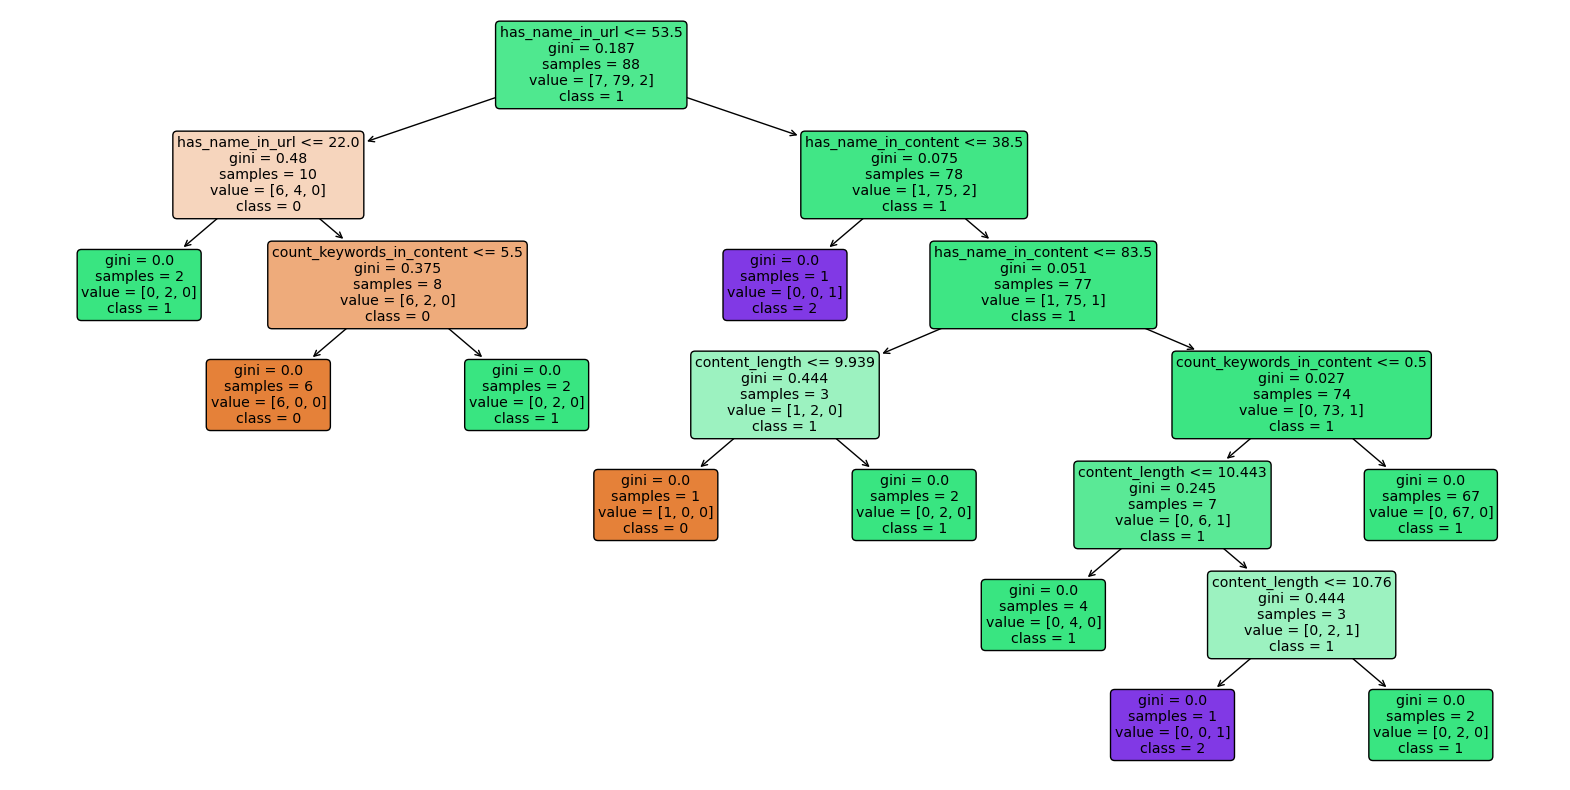

In [79]:
# Define features and target
X = df[['count_error_keywords', 'has_name_in_url', 'has_name_in_content', 'count_keywords_in_content', 'count_keywords_in_url', 'count_keywords_in_title', 'content_length']]
y = df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = DecisionTreeClassifier(ccp_alpha=0.005) #default ccp_alpha = 
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

plt.figure(figsize=(20,10))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=["0", "1", "2"], rounded=True)
plt.show()

In [74]:
print(cm)

[[ 0  2  0]
 [ 0 18  0]
 [ 1  0  2]]


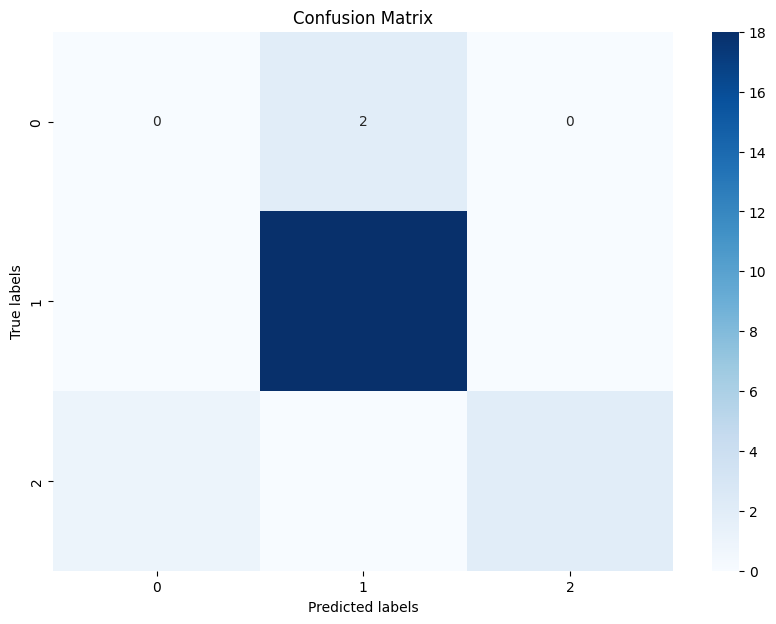

In [73]:
# Generate a confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize using Seaborn's heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=["0", "1", "2"], yticklabels=["0", "1", "2"])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Example conditioning of data set

In [ ]:
import pandas as pd

# First set of conditions leading to 57 true positives
condition_set_0 = (
    (df['has_name_in_content'] > 0.5) &
    (df['has_keywords_in_content'] > 0.5)
)

condition_set_1 = (
    condition_set_0 &
    (df['has_name_in_url'] > 0.5)
)

# Second set of conditions leading to 4 true positives
condition_set_2 = (
    condition_set_0 &
    (df['has_name_in_url'] < 0.5) &
    (df['has_error_keywords'] > 0.5)
)

# Third set of conditions leading to 3 true positives
condition_set_3 = (
    condition_set_0 &
    (df['has_name_in_url'] < 0.5) &
    (df['has_error_keywords'] < 0.5) &
    (df['has_keywords_in_url'] > 0.5)
)

# Assigning labels based on conditions
df['condition_label'] = (
    condition_set_1.astype(int) +
    condition_set_2.astype(int) +
    condition_set_3.astype(int)
)

df['condition_label'] = df['condition_label'].apply(lambda x: 1 if x >= 1 else x)

# Machine Learning Approach
- active learning?